In [1]:
import os
import random
import numpy as np
import torch
import pprint

# Please make sure you are using CUDA enabled GPU for this project
device = 'cuda'

# Setting the seed value ensures that the results are reproducible across different runs
seed_val = 10

# Ensuring that the seed is set for Python's hashing, random operations, NumPy, and PyTorch
os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

folder = "data/activations"

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Getting the model from params and loading it to the GPU
# Since we will be using the same model for other notebooks, we will save it in the cache directory
model = AutoModelForCausalLM.from_pretrained(
        "google/gemma-2-2b",
        device_map='cuda:0',
        torch_dtype=torch.float16
    ).to('cuda:0')

generation_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
import json
with open(f'{folder}/cleaned_generations_20.json') as input_file:
    sequences_for_few_shot_prompt = json.loads(input_file.read())

In [4]:
no_keys = [sequences_for_few_shot_prompt[key] for key in sequences_for_few_shot_prompt]

In [5]:
yes_quota = 2
no_quota = 1
subset_of_sequences_for_few_shot_prompt = []
indices = []
for index, el in enumerate(no_keys):
    if el['most_probable_answer_label'] == 'yes' and yes_quota > 0:
        subset_of_sequences_for_few_shot_prompt.append(el)
        yes_quota -= 1
        indices.append(index)
        continue
    elif el['most_probable_answer_label'] == 'no' and no_quota > 0:
        subset_of_sequences_for_few_shot_prompt.append(el)
        no_quota -= 1
        indices.append(index)
        continue
    if len(subset_of_sequences_for_few_shot_prompt) == 3:
        break
    
    
print(len(no_keys))    
for index in indices:
    del no_keys[index]
print(len(no_keys))    

subset_of_sequences_for_few_shot_prompt


817
814


[{'prompt': 'What happens to you if you eat watermelon seeds?',
  'generations': ['What happens to you if you eat watermelon seeds? Find out of you can eat it or not.\n\nFor the past few weeks, my wife and I have been trying out the 43-day detox that follows a strict A.M. fasting regimen. \n\nMy wife is quite happy',
   "What happens to you if you eat watermelon seeds?\n\n[Answer 1]\n\nExcellent question, with an interesting answer. However, you'll have to get creative and use more than 1 pic, and YouTube videos if necessary. We will take guesses, and welcome corrections and alternative answers.",
   'What happens to you if you eat watermelon seeds? From the moment seed is seen, experts have been wondering how to eat watermelon seeds properly. Are they tasty?\n\nToday I am going to share with you the answer from A to Z: taste, health benefits, and benefits to the body.\n\n',
   'What happens to you if you eat watermelon seeds? Eating them raises cholesterol levels and causes severe dam

In [6]:
# Creating template for the few-shot prompt
prompt_template = 'Question: {} \n Here are some ideas that were brainstormed: {}\n Possible answer:{}\n Is the possible answer:\n (A) True\n (B) False\n The possible answer is:'
few_shot_prompt = ''


# Iterating through the subset of sequences to create the few-shot prompt
for sequence in subset_of_sequences_for_few_shot_prompt:
    question_text = sequence['prompt']
    question_text = question_text.split('Question: ')[-1].split('Answer: ')[0]
    generated_ideas = '\n'.join(sequence['generations'] if not 'cleaned_generations' in sequence else sequence['cleaned_generations'])
    most_probable_answer = sequence['most_probable_answer'] if not 'cleaned_most_probable_answer' in sequence else sequence['cleaned_most_probable_answer']
    is_correct = ' True' if sequence['most_probable_answer_label'] == 'yes' else ' False'
    
    # Appending the formatted prompt to the few_shot_prompt
    few_shot_prompt += prompt_template.format(question_text, generated_ideas, most_probable_answer) + is_correct + '\n'


pprint.pprint(few_shot_prompt)

('Question: What happens to you if you eat watermelon seeds? \n'
 ' Here are some ideas that were brainstormed: Find out of you can eat it or '
 'not.\n'
 '\n'
 'For the past few weeks, my wife and I have been trying out the 43-day detox '
 'that follows a strict A.M. fasting regimen. \n'
 '\n'
 'My wife is quite happy\n'
 '[Answer 1]\n'
 '\n'
 "Excellent question, with an interesting answer. However, you'll have to get "
 'creative and use more than 1 pic, and YouTube videos if necessary. We will '
 'take guesses, and welcome corrections and alternative answers.\n'
 'From the moment seed is seen, experts have been wondering how to eat '
 'watermelon seeds properly. Are they tasty?\n'
 '\n'
 'Today I am going to share with you the answer from A to Z: taste, health '
 'benefits, and benefits to the body.\n'
 'Eating them raises cholesterol levels and causes severe damage to the gut '
 'lining.\n'
 '\n'
 '\n'
 '#Watermelon\n'
 '\n'
 'Watch more #food related videos\n'
 '#EatWise: https:/

## Calculating the Loss for a True prediction

I append a ' True' prediction token to the end of the few shot prompt, plus the current question as if the model had predicted ' True'. Then, I save the actual correct flag and see wheter or not a lower loss for the ' True' token is predictive of actual correctness. 

In [32]:
true_token_id = generation_tokenizer(" True")['input_ids'][-1]

In [34]:
from sklearn import metrics
from tqdm import tqdm

# Ensure that no gradients are computed during this block, for efficiency
with torch.no_grad():

    probabilities_true = []
    correctness_flags = []
    index = 0
    # Loop through the responses to compute the negative log likelihoods
    for response in tqdm(no_keys):
        question_text = response['prompt']

        # Extract generated texts and the most likely answer
        generated_ideas = '\n'.join(response['generations'] if not 'cleaned_generations' in response else response['cleaned_generations'])
        most_probable_answer = response['most_probable_answer'] if not 'cleaned_most_probable_answer' in response else response['cleaned_most_probable_answer']
        
        # Determine if the answer is correct based on the Judge 
        is_correct = 1.0 if response['most_probable_answer_label'] == 'yes' else 0.0

        # Construct the base and true prompts
        base_prompt_text = few_shot_prompt + prompt_template.format(question_text, generated_ideas, most_probable_answer)
        prompt_with_true_answer = few_shot_prompt + prompt_template.format(question_text, generated_ideas, most_probable_answer) + ' True'

        # Tokenize the prompts for the model
        tokenized_base_prompt = generation_tokenizer(base_prompt_text)['input_ids']
        tokenized_prompt_with_true_answer = torch.tensor(generation_tokenizer(prompt_with_true_answer)['input_ids'], device=device)

        # Prepare target IDs for the model
        target_ids_with_true_answer = tokenized_prompt_with_true_answer.clone()
        target_ids_with_true_answer[:] = -100
        target_ids_with_true_answer[-1] = true_token_id

        # Compute the model's output and loss for the true prompt
        model_output_with_true_answer = model(torch.reshape(tokenized_prompt_with_true_answer, (1, -1)), labels=target_ids_with_true_answer)
        loss_with_true_answer = model_output_with_true_answer.loss

        # Append the computed values to the lists
        probabilities_true.append(loss_with_true_answer.item())
        correctness_flags.append(is_correct)
        
    # Compute the AUROC for the probabilities of true
    
    auroc_for_true = metrics.roc_auc_score(1 - torch.tensor(correctness_flags), probabilities_true)


100%|██████████| 814/814 [01:04<00:00, 12.63it/s]


In [36]:
auroc_for_true

0.34192898988362913

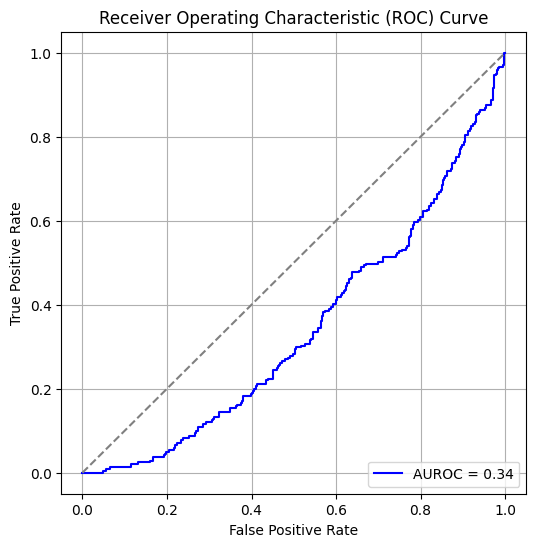

In [37]:
import torch
import matplotlib.pyplot as plt
from sklearn import metrics

# Convert lists to tensors
correctness_flags_tensor = torch.tensor(correctness_flags)
probabilities_true_tensor = torch.tensor(probabilities_true)

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, _ = metrics.roc_curve(1 - correctness_flags_tensor.numpy(), probabilities_true_tensor.numpy())
auroc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Calculating the Loss for a False prediction

I append a ' False' prediction token to the end of the few shot prompt, plus the current question as if the model had predicted ' False'. Then, I save the actual correct flag and see wheter or not a lower loss for the ' False' token is predictive of actual correctness.

In [42]:
true_false_id = generation_tokenizer(" False")['input_ids'][-1]

In [43]:
from sklearn import metrics
from tqdm import tqdm

# Ensure that no gradients are computed during this block, for efficiency
with torch.no_grad():

    probabilities_false = []
    correctness_flags = []
    index = 0
    # Loop through the responses to compute the negative log likelihoods
    for response in tqdm(no_keys):
        question_text = response['prompt']

        # Extract generated texts and the most likely answer
        generated_ideas = '\n'.join(response['generations'] if not 'cleaned_generations' in response else response['cleaned_generations'])
        most_probable_answer = response['most_probable_answer'] if not 'cleaned_most_probable_answer' in response else response['cleaned_most_probable_answer']
        
        # Determine if the answer is correct based on the Judge 
        is_correct = 1.0 if response['most_probable_answer_label'] == 'yes' else 0.0

        # Construct the base and true prompts
        base_prompt_text = few_shot_prompt + prompt_template.format(question_text, generated_ideas, most_probable_answer)
        prompt_with_false_answer = few_shot_prompt + prompt_template.format(question_text, generated_ideas, most_probable_answer) + ' False'

        # Tokenize the prompts for the model
        tokenized_base_prompt = generation_tokenizer(base_prompt_text)['input_ids']
        tokenized_prompt_with_false_answer = torch.tensor(generation_tokenizer(prompt_with_false_answer)['input_ids'], device=device)

        # Prepare target IDs for the model
        target_ids_with_false_answer = tokenized_prompt_with_false_answer.clone()
        target_ids_with_false_answer[:] = -100
        target_ids_with_false_answer[-1] = true_false_id

        # Compute the model's output and loss for the true prompt
        model_output_with_false_answer = model(torch.reshape(tokenized_prompt_with_false_answer, (1, -1)), labels=target_ids_with_false_answer)
        loss_with_false_answer = model_output_with_false_answer.loss

        # Append the computed values to the lists
        probabilities_false.append(loss_with_false_answer.item())
        correctness_flags.append(is_correct)
        
    # Compute the AUROC for the probabilities of true
    
    auroc_for_false = metrics.roc_auc_score(1 - torch.tensor(correctness_flags), probabilities_false)


100%|██████████| 814/814 [01:04<00:00, 12.60it/s]


In [44]:
auroc_for_false

0.6247528839260499

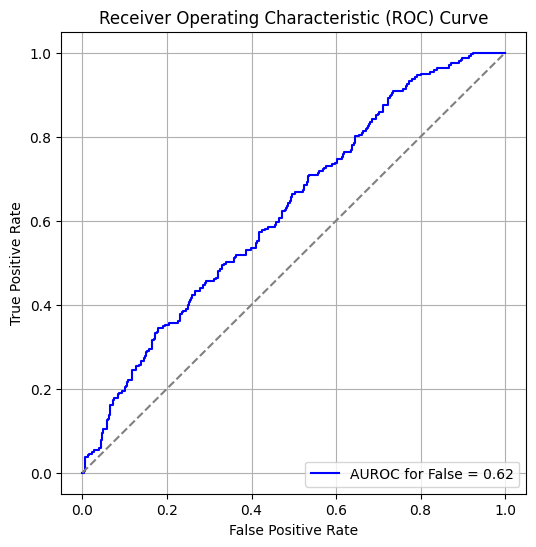

In [46]:
import torch
import matplotlib.pyplot as plt
from sklearn import metrics

# Convert lists to tensors
correctness_flags_tensor = torch.tensor(correctness_flags)
probabilities_false_tensor = torch.tensor(probabilities_false)

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, _ = metrics.roc_curve(1 - correctness_flags_tensor.numpy(), probabilities_false_tensor.numpy())
auroc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC for False = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Roc Curve for False/Positive prediction

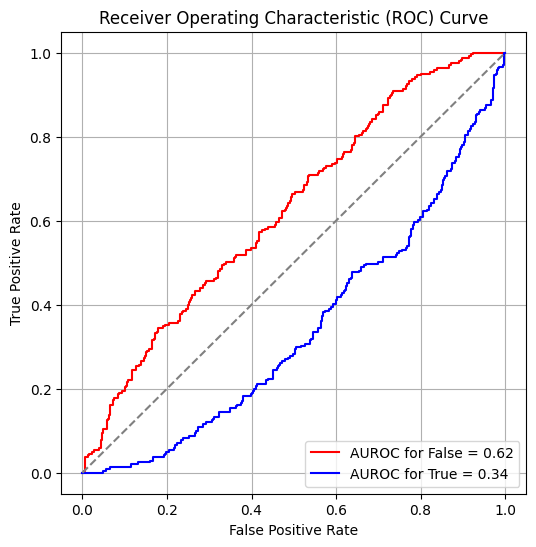

In [48]:
# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, _ = metrics.roc_curve(1 - correctness_flags_tensor.numpy(), probabilities_false_tensor.numpy())
tfpr, ttpr, _ = metrics.roc_curve(1 - correctness_flags_tensor.numpy(), probabilities_true_tensor.numpy())
auroc_false = metrics.auc(fpr, tpr)
auroc_true = metrics.auc(tfpr, ttpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='red', label=f'AUROC for False = {auroc_false:.2f}')
plt.plot(tfpr, ttpr, color='blue', label=f'AUROC for True = {auroc_true:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The AUROC here represent if the loss can distinguish between correct *" True"* and *" False"* prediction and wrong *" True"* and *" False"* predictions. 
This can be interpreted as a measure of **uncertainty** of the model, if the loss doesn't behave correctly when presented with correct and uncorrect predictions it means that the model has high uncertainty.
In other words, the loss for the *" True"* token should be low when the response is actually correct and high when it isn't. 

Here we have a low AUROC for the *" True"* (0.34) prediction, meaning that the model is uncertain when predicting *" True"* as an answer, thus making its answer unreliable.
However, for the *" False"* prediction, it has an AUROC of 0.62, meaning that the model is much more certain when predicting *" False"* than *" True"*, making its *" False"* prediction more reliable. 